# Traitement du Signal - TP3 : Transformée de Fourier (Partie 2)

Ce TP complète ce qui a été vu dans le TP3, avec deux nouveaux exercices. Voilà... après, s'il n'y a pas plus de trucs à dire... pas besoin de faire plus long...

Vous pouvez directement copier les cellules pour les mettre à la fin du TP3 précédent, ou alors juste compléter ce notebook séparément. Faites comme vous voulez

In [1]:
import numpy as np
from matplotlib import pyplot as plt

---

## Exercice 6 : Comment compresser un signal ?

Dans cet exercice, on va voir comment on peut **compresser** théoriquement un signal, grâce à sa représentation fréquentielle. Pour cela, il nous faut un signal. Tracez le signal **périodique** carré de période $T$ et d'amplitude $A$, dont l'équation de la période est la suivante : 

\begin{equation*}
    c(t) = \left \{
            \begin{array}{ll}
                A & 0 \leq t \leq \frac{T}{2}\\
                -A & \frac{T}{2} \leq t \leq T \\
            \end{array}
            \right.
\end{equation*}

Le signal évoluera de 0 à 1 secondes avec une fréquence d'échantillonage $f_e = 10000$ Hz. La période $T$ est de 0.1 secondes, et l'amplitude $A$ est à 1.

Créez et tracez ce signal.

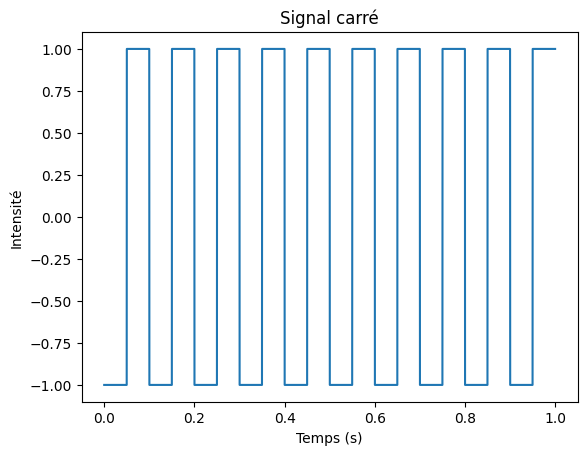

In [2]:
# A COMPLETER

# Création de l'axe temporel
duration = 1 # Durée du signal
fe = 10000 # Fréquence d'échantillonage
t = np.arange(0, duration, 1/fe)

# Création du signal carré
A = 1 # Amplitude
T = 0.1 # Période du signal
c = np.ones_like(t) * A
c[t%T<T/2] = -A

# Affichage du signal carré
plt.plot(t,c)
plt.title("Signal carré")
plt.xlabel("Temps (s)")
plt.ylabel("Intensité")
plt.show()

Effectuez maintenant une transformée de Fourier réelle sur le signal carré, et affichez le spectre d'amplitude.

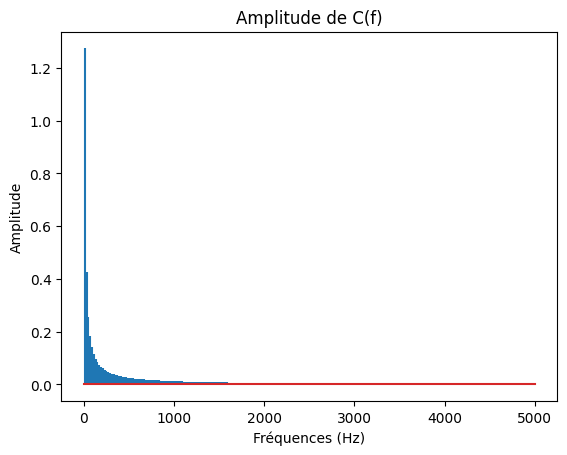

In [3]:
# Transformée de Fourier réelle du signal c(t)
C = np.fft.rfft(c) # Calcul de la FFT réelle du signal
freq_C = np.fft.rfftfreq(len(c),1/fe) # Calcul de l'axe fréquentiel de la FFT

amplitude_C = np.abs(C) *2/len(c) # Correction de l'amplitude avec le facteur de normalisation

# Affichage du spectre d'amplitude de C(f)
plt.stem(freq_C, amplitude_C, markerfmt=" ")
plt.title("Amplitude de C(f)")
plt.xlabel("Fréquences (Hz)")
plt.ylabel("Amplitude")
plt.show()

**_QUESTION :_** Quel est la précision spectrale ? *(c'est-à-dire l'écart entre 2 fréquences analysées après Transformée de Fourier)*

In [4]:
print(f"Fréquences analysées : {freq_C}")
print(f"Précision spectrale : {freq_C[1]-freq_C[0]} Hz")

Fréquences analysées : [0.000e+00 1.000e+00 2.000e+00 ... 4.998e+03 4.999e+03 5.000e+03]
Précision spectrale : 1.0 Hz


**_REPONSE :_** La précision spectrale se définit par $\frac{f_e}{N}$ avec $f_e$ la fréquence d'échantillonage, et $N$ le nombre de points temporels. Ici, $f_e = 10000$ Hz et $N = 10000$, donc la précision spectrale est de $1$ Hz. 

Affichez ensuite le spectre d'amplitude mais zoomé sur les 1000 premières fréquences.

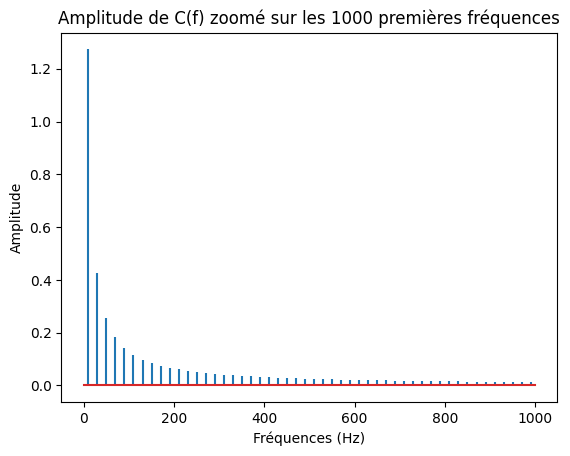

In [5]:
# Affichage du spectre d'amplitude de C(f) sur les 1000 premières fréquences
plt.stem(freq_C[:1000], amplitude_C[:1000], markerfmt=" ")
plt.title("Amplitude de C(f) zoomé sur les 1000 premières fréquences")
plt.xlabel("Fréquences (Hz)")
plt.ylabel("Amplitude")
plt.show()

**_QUESTION :_** Au vu du spectre d'amplitude zoomé, quelle est la fréquence fondamentale du signal ? Quelles sont les harmoniques ?

*Note : Je vous conseille d'utiliser la fonction find_peaks de scipy pour détecter les pics importants de votre spectre d'amplitude*

In [6]:
from scipy.signal import find_peaks

peaks, properties = find_peaks(amplitude_C, height=np.max(amplitude_C)*0.01)

print(f"Fréquence fondamentale : {peaks[0]} Hz")
print(f"Fréquences harmoniques (en Hz) : {peaks[1:]}")

Fréquence fondamentale : 10 Hz
Fréquences harmoniques (en Hz) : [ 30  50  70  90 110 130 150 170 190 210 230 250 270 290 310 330 350 370
 390 410 430 450 470 490 510 530 550 570 590 610 630 650 670 690 710 730
 750 770 790 810 830 850 870 890 910 930 950]


**_REPONSE :_** Avec *find_peaks*, on détecte les différents pics de fréquences importants (avec une amplitude significative). La fréquence fondamentale est la première dont l'amplitude est significative, donc ici 10 Hz. Les harmoniques correspondent à des fréquences à amplitude significative multiples de la fondamentale ($K \times f_0$).

**_QUESTION :_** Est-ce que les valeurs calculées correspondent à la théorie ? *(cf : Ex 2.2 c du TD)*

**_REPONSE :_** Oui, ça correspond. La fréquence fondamentale de $10$ Hz correspond à l'inverse de la période du signal $T = 0.1 s$. La DSF du signal effectuée en TD a mené à la formule suivante : 

\begin{equation*}
    c(t) = \frac{AT}{4} + \sum_{n \in \Z} \frac{A}{j \pi n} (1 - (-1)^{n}) e^{j \frac{2 \pi}{T} nt}
\end{equation*}

Avec cette décomposition, on a des harmoniques multiples de $\frac{1}{T}$ (donc $f_0$) lorsque $n$ est impair, ce qui explique pourquoi il y'a un gap de $20$ Hz entre chaque pic.


L'objectif de la compression ici va être de simplifier le signal en ne gardant que les plus grandes amplitudes du signal. Il y'a 2 manières de réaliser cela:
- Ne gardez que les $K$ fréquences avec les plus grandes amplitudes
- Ne gardez que les fréquences dont l'amplitude est supérieure à un seuil défini

Les fréquences significatives sont donc conservées, et les autres sont mises à zéro.

Implémentez dans un premier temps la fonction permettant de ne garder que les $K$ fréquences les plus significatives (c'est-à-dire avec la plus grande amplitude). Votre fonction prendra en entrée un signal fréquentiel et un nombre $K$ de fréquences à garder, et retournera le signal fréquentiel modifié.

In [7]:
# A COMPLETER
# Développement de la fonction qui sélectionne les K fréquences les plus significatives
def keep_K_freq(tf_signal, K):
    
    amplitude_tf_signal = np.abs(tf_signal) # On extrait l'amplitude du signal
    
    # On trie les valeurs d'amplitudes par ordre croissant, et on récupère les valeurs des indices via argsort
    # [::-1] permet de retourner le vecteur pour avoir un tri décroissant
    indices_sort_amplitude = np.argsort(amplitude_tf_signal)[::-1]

    # On récupère les indices des K plus grandes fréquences
    indices_K_frequences = indices_sort_amplitude[:K]

    # On crée un nouveau signal fréquentiel mis à zéro et on copie les valeurs des K plus grandes fréquences du signal original
    tf_signal_K_freq = np.zeros_like(tf_signal)
    tf_signal_K_freq[indices_K_frequences] = tf_signal[indices_K_frequences]

    return tf_signal_K_freq    

Appliquez votre fonction sur la TF du signal carré pour ne garder que les 5 fréquences les plus significatives. Affichez ensuite le spectre d'amplitude.

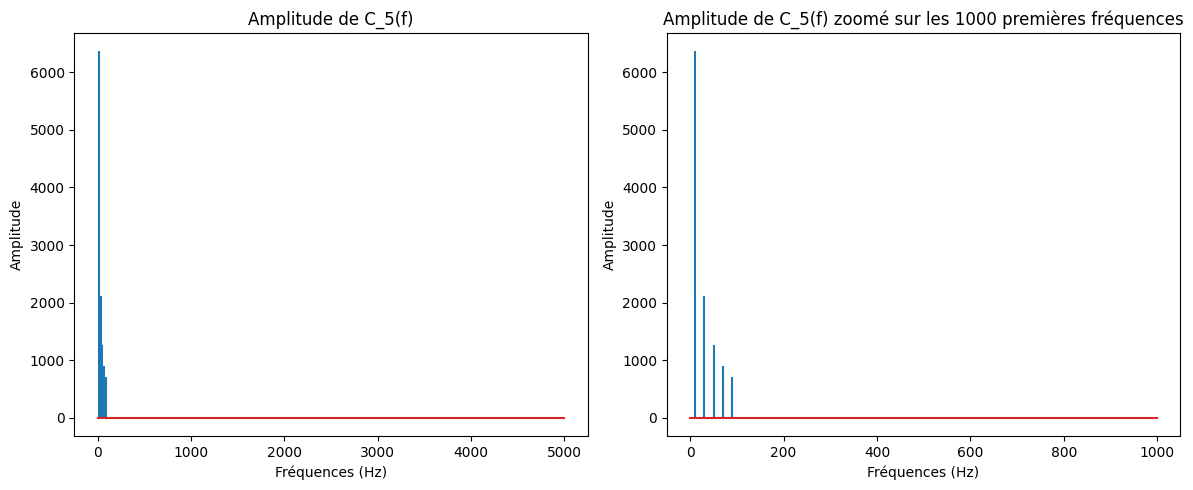

In [8]:
# A COMPLETER
# Modification de la TF du signal carré pour ne garder que les 5 fréquences les plus significatives
C_5 = keep_K_freq(C,5)

# Affichage du spectre d'amplitude du signal fréquentiel modifié
amplitude_C_5 = np.abs(C_5)
plt.subplots(1,2,figsize=(12,5))
plt.subplot(121)
plt.stem(freq_C, amplitude_C_5, markerfmt=" ")
plt.title("Amplitude de C_5(f)")
plt.xlabel("Fréquences (Hz)")
plt.ylabel("Amplitude")
plt.subplot(122)
plt.stem(freq_C[:1000], amplitude_C_5[:1000], markerfmt=" ")
plt.title("Amplitude de C_5(f) zoomé sur les 1000 premières fréquences")
plt.xlabel("Fréquences (Hz)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

Effectuez la transformée inverse sur ce nouveau signal fréquentiel, et affichez le résultat sur une même figure avec le signal original.

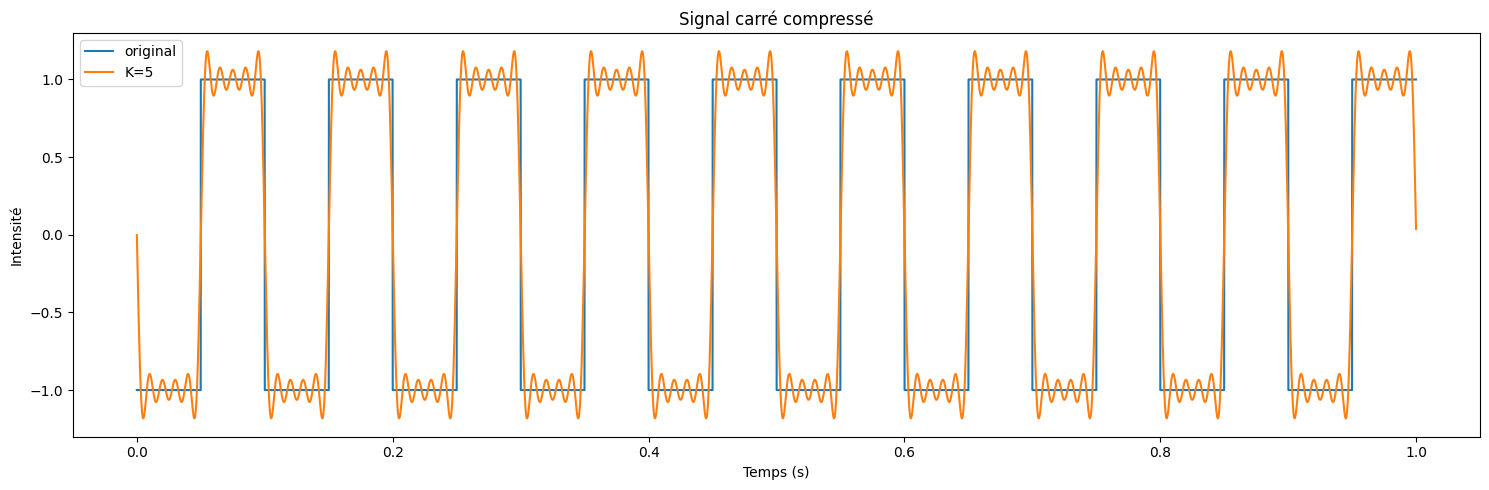

In [9]:
# A COMPLETER
# TF inverse du nouveau signal fréquentiel
c_5 = np.fft.irfft(C_5)

# Affichage des deux signaux temporels sur une même figure
plt.figure(figsize=(15,5))
plt.plot(t,c, label='original')
plt.plot(t,c_5, label='K=5')
plt.title("Signal carré compressé")
plt.xlabel("Temps (s)")
plt.ylabel("Intensité")
plt.legend()
plt.tight_layout()
plt.show()

Afin de mesurer la ressemblance entre le signal original et le signal compressé, on va calculer le **rapport signal sur bruit**. Pour rappel, cette métrique indique la puissance du signal par rapport à la puissance de son bruit. Plus le rapport est grand, plus le signal est puissant par rapport à son bruit, et donc plus le bruit est faible. Pour cela, nous allons utiliser la formule suivante :

\begin{equation*}
    R_{S/B} = 10*log_{10}(\frac{\sum c[n]²}{\sum(c[n]-ĉ[n])²})
\end{equation*}

Ici, $c$ correspond à notre signal original et $ĉ$ notre signal compressé. Le bruit est donc la différence entre le signal original et le signal compressé. De ce fait, plus le rapport est grand, plus la puissance du signal est grande par rapport à la puissance de la différence entre les deux signaux, et donc plus le signal compressé est proche du signal original.

La mesure se calcule en décibels (dB), afin d'utiliser une échelle logarithmique plus lisible :
- *0 dB* : Le signal et l'erreur ont la même puissance, donc le signal compressé est très loin de représenter le signal original
- *> 10 dB* : Le signal domine clairement le bruit
- *20-30 dB* : On a une bonne qualité de reconstruction
- *40 dB* : Le signal compressé est quasi indiscernable de l'original.

Développez une fonction de calcul de rapport signal sur bruit, et appliquez la fonction sur votre signal original et votre signal compressé

In [10]:
# A COMPLETER
# Fonction de calcul du rapport S/B
def rapport_sb(signal,signal_compresse):
    return 10 * np.log10(np.sum(signal.astype(float)**2) / np.sum((signal.astype(float) - signal_compresse.astype(float))**2))

print(f"Rapport S/B à K=5 : {rapport_sb(c,c_5)} dB")

Rapport S/B à K=5 : 13.93387799953822 dB


Répétez les mêmes opérations pour avoir sur la même figure le signal original et plusieurs versions compressées du signal ($K = 1, 5, 20, 100$).

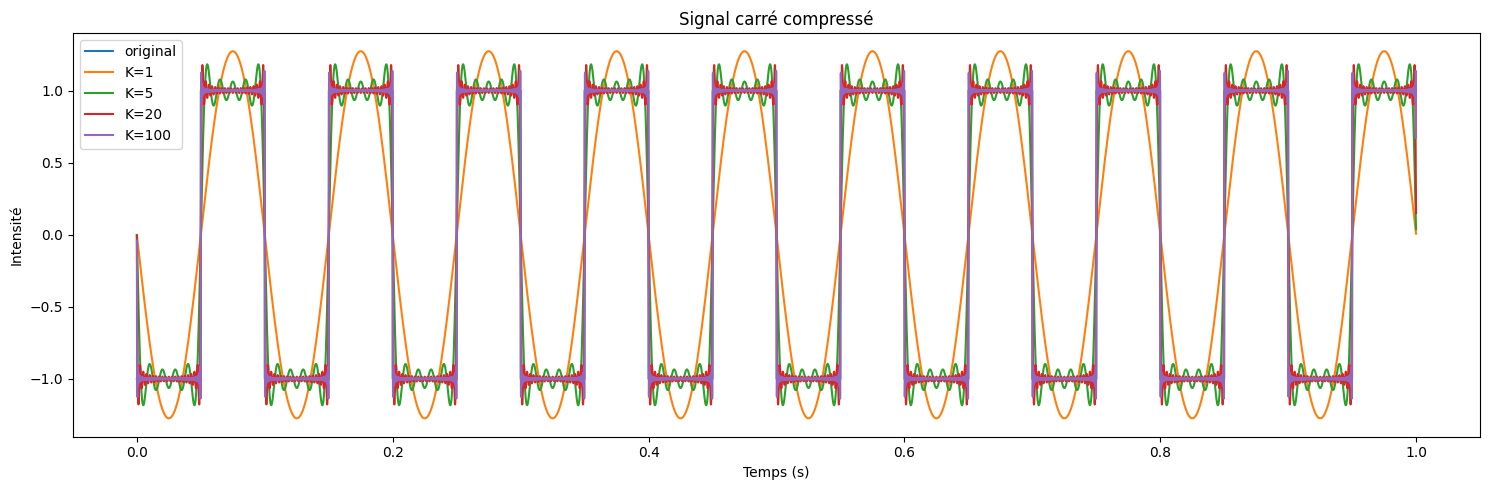

In [11]:
# A COMPLETER
# Affichage du signal original et de ses versions compressées
plt.figure(figsize=(15,5))
plt.plot(t,c,label='original')
K_valeurs = [1,5,20,100]
for K in K_valeurs:
    C_K = keep_K_freq(C,K)
    c_K = np.fft.irfft(C_K)
    plt.plot(t,c_K, label=f'K={K}')
plt.title("Signal carré compressé")
plt.xlabel("Temps (s)")
plt.ylabel("Intensité")
plt.legend()
plt.tight_layout()
plt.show()

Calculez les différents rapports $S/B$ en variant $K$ par puissances de 2 (jusqu'à $K = N$, le nombre d'échantillons de fréquences). Tracez la courbe du rapport $S/B$ en fonction de $K$.

*Note : En récupérant le nombre de bits pour coder $N$ (N.bit_length()), on peut trouver facilement la dernière puissance de 2 inférieure à $N$*

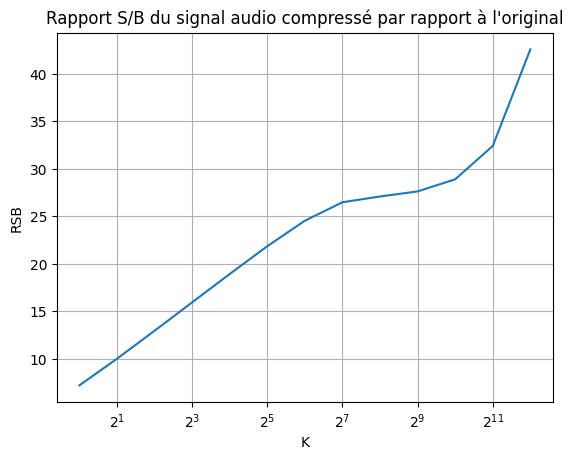

In [12]:
# A COMPLETER
# Compression du signal avec K variant en puissances de 2

N = len(freq_C) # Nombre d'échantillons de fréquences
K_values = []
RSB_values = []
for i in range(N.bit_length()): # On itère de i=0 à i= N.bit_length()-1, donc jusqu'à la dernière puissance de 2 inférieure à N (2**i)
    K = 2**i
    C_K = keep_K_freq(C,K) # On ne garde que les K fréquences les plus significatives
    c_K = np.fft.irfft(C_K) # On convertit en temporel
    K_values.append(K)
    RSB_values.append(rapport_sb(c,c_K))

# Affichage du rapport S/B en fonction de K
fig, ax = plt.subplots()
ax.set_xscale('log', base=2)
plt.plot(K_values,RSB_values)
plt.title("Rapport S/B du signal audio compressé par rapport à l'original")
plt.xlabel("K")
plt.ylabel("RSB")
ax.grid()
plt.show()

**_QUESTION :_** A partir de quelle valeur de $K$ a-t-on une compression acceptable ?

**_REPONSE :_**
Tout dépend de ce qu'on appelle *acceptable* ici. Si on reprend les définitions expliquées au-dessus, on considère que la qualité de reconstruction est bonne à partir d'un rapport $S/B$ supérieur à 20 dB. De ce fait, on atteint ce seuil à k = 2^{5} = 32.

## Exercice 7 : Mon audio est beaucoup trop lourd...

J'ai trop peu d'espace sur mon ordi, au point de ne plus avoir la place pour mon nouveau son. Vous pouvez m'aider ?

Chargez l'audio *music.wav* et tracez le signal.

/tmp/ipykernel_20734/1836422975.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  freq_music, music = wavfile.read('music.wav')


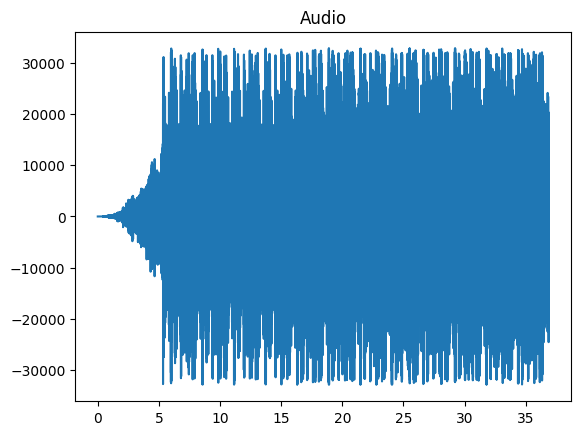

In [13]:
# A COMPLETER
# Chargement et affichage de music.wav

from scipy.io import wavfile
freq_music, music = wavfile.read('music.wav')

t = np.arange(0, len(music)/freq_music, 1/freq_music)

plt.plot(t,music)
plt.title("Audio")
plt.show()

Effectuez une transformée de Fourier réelle sur le signal audio et affichez le spectre d'amplitude du résultat obtenu.

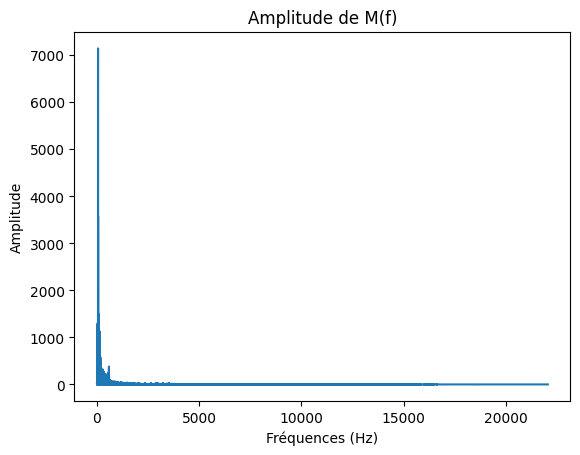

In [14]:
# A COMPLETER
# Transformée de Fourier réelle de l'audio
M = np.fft.rfft(music) # Calcul de la FFT réelle du signal
freq_M = np.fft.rfftfreq(len(music),1/freq_music) # Calcul de l'axe fréquentiel de la FFT

amplitude_M = np.abs(M) *2/len(music) # Correction de l'amplitude avec le facteur de normalisation

# Affichage du spectre d'amplitude de M(f)
plt.plot(freq_M, amplitude_M)
plt.title("Amplitude de M(f)")
plt.xlabel("Fréquences (Hz)")
plt.ylabel("Amplitude")
plt.show()

Comme effectué dans l'exercice précédent, compressez votre signal en ne gardant que $K$ composantes, avec $K$ variant en puissances de 2 jusqu'à $K=N$. Calculez le rapport signal sur bruit à chacun des $K$ et tracez la courbe du rapport $S/B$ en fonction de $K$.

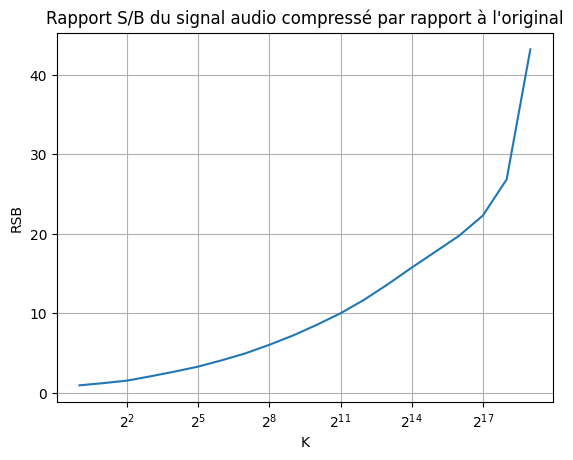

In [15]:
# A COMPLETER
# Compression du signal avec K variant en puissances de 2

N = len(freq_M) # Nombre d'échantillons de fréquences
K_values = []
RSB_values = []
for i in range(N.bit_length()): # On itère de i=0 à i= N.bit_length()-1, donc jusqu'à la dernière puissance de 2 inférieure à N (2**i)
    K = 2**i
    M_K = keep_K_freq(M,K) # On ne garde que les K fréquences les plus significatives
    music_K = np.fft.irfft(M_K,n=len(music)) # On convertit en temporel
    K_values.append(K)
    RSB_values.append(rapport_sb(music,music_K))

# Affichage du rapport S/B en fonction de K
fig, ax = plt.subplots()
ax.set_xscale('log', base=2)
plt.plot(K_values,RSB_values)
plt.title("Rapport S/B du signal audio compressé par rapport à l'original")
plt.xlabel("K")
plt.ylabel("RSB")
ax.grid()
plt.show()

Récupérez les valeurs minimums de $K$ tels que le rapport $S/B$ est supérieur ou égal à 10, 20 et 30 dB. Compressez l'audio original avec ces 3 valeurs de $K$ et enregistrez les différentes versions dans un fichier WAV.

In [16]:
# A COMPLETER
# Récupération des K minimums tels que le rapport S/B est supérieur ou égal à 10, 20 et 30 dB
seuils = [10,20,30] # Les seuils à atteindre en dB
for seuil in seuils:
    # On cherche la valeur de K minimum dont le rapport S/B dépasse le seuil
    for i in range(len(K_values)):
        if RSB_values[i]>seuil:
            K = 2**i
            print(f"K pour seuil de {seuil} dB : {K} ({K/len(freq_M)*100}% des fréquences de l'audio)")
            break # On arrête la boucle car on a trouvé la valeur K
        if i==len(K_values)-1: # Aucune valeur de K n'a un rapport S/B supérieur à notre seuil : on prned K = N
            K = len(freq_M)
    M_K = keep_K_freq(M,K) # On ne garde que les K fréquences les plus significatives
    music_K = np.fft.irfft(M_K) # On convertit en temporel
    wavfile.write(f"music_compressed_{seuil}_dB.wav", freq_music, music_K.astype(np.int16))

K pour seuil de 10 dB : 2048 (0.2518547850564521% des fréquences de l'audio)
K pour seuil de 20 dB : 131072 (16.118706243612934% des fréquences de l'audio)
K pour seuil de 30 dB : 524288 (64.47482497445174% des fréquences de l'audio)


**_QUESTION :_** Comment est la qualité sonore des différents extraits compressés ?

**_REPONSE :_**
- Pour la compression avec un rapport *S/B* à 10 dB, la musique n'est pas reconnaissable du tout
- Pour la compression avec un rapport *S/B* à 20 dB, on reconnaît la musique, mais avec un fort bruit tout au long de l'extrait
- Pour la compression avec un rapport *S/B* à 30 dB, on reconnaît également la musique, et il y a toujours un bruit durant l'extrait, mais il est plus faible

Ce qui est donc intéressant, c'est qu'en ayant supprim"er" un bon nombre de fréquences à faibles amplitudes (36% en moins pour le 30 dB, 84% en moins pour le 20 dB), on a réussi tout de même à conserver la mélodie, ce qui montre qu'au final, un petit nombre de fréquences constitue la mélodie.

**_QUESTION :_** Est-ce que les fichiers compressés ont un poids plus léger (en octets) ?

**_REPONSE :_** Non, et c'est normal car le format WAV enregistre les échantillons temporels bruts. Ce n'est pas un format compressé. Il y a beau avoir moins de fréquences présentes dans l'audio, ça ne change rien à la taille de l'audio (axe temporel), donc le fichier reste de même taille.

---

*Le résultat n'est pas concluant ? C'est normal !*

La compression audio ne fonctionne pas exactement comme ça... Le principe reste le même : éliminer des fréquences inutiles en les mettant à zéro. Cependant, c'est fait de manière plus intelligente :
- On supprime les fréquences audios inperceptibles par l'oreille humaine
- On supprime les fréquences inaudibles dans le contexte (ex: un son fort à 1kHz rend inaudible un son plus faible à 1,05 kHz)

Ensuite, les autres fréquences ne sont pas laissées telles qu'elles, mais elles sont quantifiées. Cela consiste à donner moins de précision sur les fréquences à faible amplitude tout en conservant une grande précision pour les fréquences à forte amplitude. De ce fait, on réduit drastiquement la taille requise pour encoder le signal audio, et donc on peut compresser efficacement un fichier.

Bref, votre expérience n'a pas fonctionné, mais ça nous a permis de voir dans les grandes lignes la base de la compression MP3 !